<a href="https://colab.research.google.com/github/Nastarii/Drowsiness-Detection/blob/main/Labeling_Process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face detection using pre-trained model

We use following blog as a reference:
[Face detection with OpenCV and deep learning](https://www.pyimagesearch.com/2018/02/26/face-detection-with-opencv-and-deep-learning/)

Import required Python libraries

In [47]:
import imutils
import ipywidgets as widgets
import pandas as pd
import numpy as np
import cv2
import os

from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from IPython.display import clear_output, Image
from google.colab.output import eval_js
from base64 import b64decode
from google.colab import drive
from tqdm.notebook import tqdm

drive.mount('./drive')

Drive already mounted at ./drive; to attempt to forcibly remount, call drive.mount("./drive", force_remount=True).


In [8]:
!pip install keyboard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 1.0 MB/s eta 0:00:00


In [2]:
DRIVE_PATH = './drive/Shareddrives/TCC_Drowsiness_Detection'

In [3]:
!mkdir images
!unzip -qq $DRIVE_PATH/images.zip -d ./images

In [44]:
def name_format(num):
  if num < 10:
    prefixo = '0000'
  elif num >= 10 and num < 100:
    prefixo = '000'
  elif num >= 100 and num < 1000:
    prefixo = '00'
  elif num >= 1000 and num < 10000:
    prefixo = '0'
  return f'{prefixo}{num}'

In [45]:
def get_filenames():

  filenames = []

  for i in range(9120):
    filenames.append(f'IMG_{name_format(i)}.jpg')
  return filenames

Image Shape:(400,264)


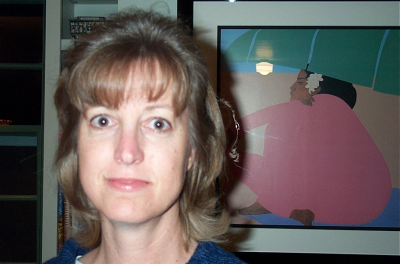

In [46]:
# images informations
IMG_PATH = './images'
filenames = get_filenames()
indice = 53

image = cv2.imread(f'{IMG_PATH}/{filenames[indice]}', 1)

# resize it to have a maximum width of 400 pixels
# Show the indice image of the dataset
image = imutils.resize(image, width=400)
(h, w) = image.shape[:2]
print(f'Image Shape:({w},{h})')
cv2_imshow(image)

OpenCV’s deep learning face detector is based on the Single Shot Detector (SSD) framework with a ResNet base network. The network is defined and trained using the [Caffe Deep Learning framework](https://caffe.berkeleyvision.org/)

Download the pre-trained face detection model, consisting of two files:

- The network definition (deploy.prototxt)
- The learned weights (res10_300x300_ssd_iter_140000.caffemodel)

In [5]:
!wget -N https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -N https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

--2023-08-10 22:37:38--  https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28104 (27K) [text/plain]
Saving to: ‘deploy.prototxt’

deploy.prototxt     100%[===================>]  27.45K  --.-KB/s    in 0.004s  

Last-modified header missing -- time-stamps turned off.
2023-08-10 22:37:38 (7.49 MB/s) - ‘deploy.prototxt’ saved [28104/28104]

--2023-08-10 22:37:39--  https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubus

Load the pre-trained face detection network model from disk

In [6]:
print("[INFO] loading model...")
prototxt = 'deploy.prototxt'
model = 'res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNetFromCaffe(prototxt, model)

[INFO] loading model...


## Applying the object detection in our dataset

In [39]:
!mkdir /content/labeledImages/

In [52]:
# Variable to store the detection data
data = []
descartadas = 0

# Iterate over image filenames
for filename in tqdm(filenames):

  clear_output()

  # Get the number of the image
  img_number = int(filename.replace('IMG_','').replace('.jpg', ''))

  if img_number <= 4:

    # Define the label
    if img_number < 4560:
      classe = 'Acordado'
    else:
      classe = 'Sonolento'

    # Read image as array
    image = cv2.imread(f'{IMG_PATH}/{filename}', 1)

    cp_image = image.copy()

    # Get image shape
    width, height = cp_image.shape[:2]

    # Use the dnn.blobFromImage function to construct an input blob by resizing
    # the image to a fixed 300x300 pixels and then normalizing it.
    # resize it to have a maximum width of 400 pixels
    image = imutils.resize(image, width=400)
    x_new, y_new = image.shape[:2]

    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

    # Pass the blob through the neural network and obtain the detections and predictions.
    net.setInput(blob)
    detections = net.forward()

    best_confidence = max(detections[0, 0, :, 2])
    # Loop over the detections and draw boxes around the detected faces
    for i in range(0, detections.shape[2]):

      # extract the confidence (i.e., probability) associated with the prediction
      confidence = detections[0, 0, i, 2]

      # filter out weak detections by ensuring the `confidence` is
      # greater than the minimum confidence threshold
      if confidence == best_confidence:

        # compute the (x, y)-coordinates of the bounding box for the object
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")

        scale = y_new/400

        # draw the bounding box of the face along with the associated probability
        print(f"Imagem Número:{img_number}")
        print(f"Descartadas:{descartadas}")

        cv2.rectangle(image, (startX, int(startY * scale)), (endX, int(endY * scale)), (222, 0, 0), 2)

    new_filename = f'IMG_{name_format(img_number - descartadas)}.jpg'
    new_image_path= f'/content/labeledImages/{new_filename}'
    cv2.imwrite(new_image_path, image)

    # Criar um widget de imagem
    image_widget = widgets.Image(value=open(new_image_path, "rb").read())

    # Exibir a VBox
    display(image_widget)


    response = input("Descartar Imagem[S/N]:")


    if response == 'S':
      descartadas += 1

    else:
      data.append([new_filename, width, height, classe, startX, startY, endX, endY ])
  else:
    df = pd.DataFrame(data, columns=['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax'])
    df.to_csv('test.csv', index=False)
    break


Use the [dnn.blobFromImage](https://www.pyimagesearch.com/2017/11/06/deep-learning-opencvs-blobfromimage-works/) function to construct an input blob by resizing the image to a fixed 300x300 pixels and then normalizing it.


In [ ]:
for i in range(0, detections.shape[2]):

	# extract the confidence (i.e., probability) associated with the prediction
	confidence = detections[0, 0, i, 2]

	# filter out weak detections by ensuring the `confidence` is
	# greater than the minimum confidence threshold
	if confidence > 0.5:
		# compute the (x, y)-coordinates of the bounding box for the object
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")
		# draw the bounding box of the face along with the associated probability
		text = "{:.2f}%".format(confidence * 100)
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
		cv2.putText(image, text, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

Show the resulting image